In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='-1'
import tensorflow.compat.v1 as tf
from tensorflow.contrib.opt import ScipyOptimizerInterface
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import random
import sys
np.set_printoptions(threshold=sys.maxsize)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
class DNN:
    def __init__(self):
        pass
    
    def hyper_initial(self, layers):
        L = len(layers)
        W = []
        b = []
        for l in range(1, L):
            in_dim = layers[l-1]
            out_dim = layers[l]
            std = np.sqrt(2/(in_dim + out_dim))
            weight = tf.Variable(tf.random_normal(shape=[in_dim, out_dim], stddev=std))
            bias = tf.Variable(tf.zeros(shape=[1, out_dim]))
            W.append(weight)
            b.append(bias)

        return W, b

    def fnn(self, W, b, X, Xmin, Xmax):
        A = 2.0*(X - Xmin)/(Xmax - Xmin) - 1.0
        L = len(W)
        for i in range(L-1):
            A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        
        return Y


In [3]:
n = 0
LOSS = []
def callback(loss_):
    global n
    global LOSS
    LOSS = np.hstack((LOSS,loss_))
    n += 1
    if n%1000 == 0:
        print('n: %d, loss: %.3e'%(n, loss_))

In [4]:
YH1_train = np.genfromtxt('Vis_Train_H.txt')
XH1_train = np.genfromtxt('C01_Train_H.txt')
XH2_train = np.genfromtxt('Sur_Train_H.txt')
XH3_train = np.genfromtxt('Oth_Train_H.txt')
XH4_train = np.genfromtxt('Slt_Train_H.txt')
XH5_train = np.genfromtxt('Shr_Train_H.txt')

YH1_train = YH1_train.reshape((-1,1))
XH1_train = XH1_train.reshape((-1,1))
XH2_train = XH2_train.reshape((-1,1))
XH3_train = XH3_train.reshape((-1,1))
XH4_train = XH4_train.reshape((-1,1))
XH5_train = XH5_train.reshape((-1,1))

In [5]:
YH1_test = np.genfromtxt('Vis_Test_H.txt')
XH1_test = np.genfromtxt('C01_Test_H.txt')
XH2_test = np.genfromtxt('Sur_Test_H.txt')
XH3_test = np.genfromtxt('Oth_Test_H.txt')
XH4_test = np.genfromtxt('Slt_Test_H.txt')
XH5_test = np.genfromtxt('Shr_Test_H.txt')

YH1_test = YH1_test.reshape((-1,1))
XH1_test = XH1_test.reshape((-1,1))
XH2_test = XH2_test.reshape((-1,1))
XH3_test = XH3_test.reshape((-1,1))
XH4_test = XH4_test.reshape((-1,1))
XH5_test = XH5_test.reshape((-1,1))

In [6]:
y_hf = YH1_train.reshape(1,-1).T
x_hf = XH1_train.reshape(1,-1).T
t_hf = XH2_train.reshape(1,-1).T
u_hf = XH3_train.reshape(1,-1).T
w_hf = XH4_train.reshape(1,-1).T
p_hf = XH5_train.reshape(1,-1).T

X_hf = np.hstack((x_hf,t_hf,u_hf,w_hf,p_hf))

Xmin = X_hf.min(0)
Xmax = X_hf.max(0)
Ymin = y_hf.min(0)
Ymax = y_hf.max(0)

Xhmin = np.hstack((Xmin, Ymin))
Xhmax = np.hstack((Xmax, Ymax))

In [7]:
D = 5
layers_hf = [D] + 2*[20] + [1]

x_train_hf = tf.placeholder(shape=[None, D], dtype=tf.float32)
y_train_hf = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [8]:
model = DNN()
W_hf, b_hf = model.hyper_initial(layers_hf)
y_pred_hf = model.fnn(W_hf, b_hf, x_train_hf, Xmin, Xmax)

In [9]:
loss = tf.reduce_mean((tf.square(y_pred_hf - y_train_hf)))
train_adam = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
train_lbfgs = ScipyOptimizerInterface(loss,
                                      method = 'L-BFGS-B', 
                                      options={'maxiter': 50000,
                                               'ftol': 1.0*np.finfo(float).eps
                                              })

In [10]:
tf.set_random_seed(1373)
random.seed(1373)
np.random.seed(1373)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

### Compile the cell below just only for model loading

In [11]:
#model = saver.restore(sess, 'DNNModel/DNNModel')

In [15]:

loss_ = 1.0
train_dict = {x_train_hf: X_hf, y_train_hf: y_hf}
print('Adam Optimizer')
while n < 100000 and loss_ > 1e-6:
    n += 1
    loss_, _ = sess.run([loss, train_adam], feed_dict=train_dict)
    LOSS = np.hstack((LOSS,loss_))
    if n%1000 == 0:
        print('n: %d, loss: %.3e'%(n, loss_))

print('LBFG-S Optimizer')
train_lbfgs.minimize(sess, feed_dict=train_dict, fetches=[loss], loss_callback=callback)

print("Training is done!")

Adam Optimizer
n: 51000, loss: 5.044e-05
n: 52000, loss: 5.086e-05
n: 53000, loss: 4.854e-05
n: 54000, loss: 5.372e-05
n: 55000, loss: 4.776e-05
n: 56000, loss: 4.822e-05
n: 57000, loss: 4.588e-05
n: 58000, loss: 4.490e-05
n: 59000, loss: 4.433e-05
n: 60000, loss: 4.376e-05
n: 61000, loss: 4.675e-05
n: 62000, loss: 6.556e-05
n: 63000, loss: 4.222e-05
n: 64000, loss: 4.180e-05
n: 65000, loss: 4.266e-05
n: 66000, loss: 4.082e-05
n: 67000, loss: 4.044e-05
n: 68000, loss: 4.351e-05
n: 69000, loss: 3.962e-05
n: 70000, loss: 3.975e-05
n: 71000, loss: 4.100e-05
n: 72000, loss: 3.853e-05
n: 73000, loss: 3.892e-05
n: 74000, loss: 3.978e-05
n: 75000, loss: 4.144e-05
n: 76000, loss: 3.722e-05
n: 77000, loss: 3.693e-05
n: 78000, loss: 3.697e-05
n: 79000, loss: 3.646e-05
n: 80000, loss: 3.632e-05
n: 81000, loss: 3.585e-05
n: 82000, loss: 3.563e-05
n: 83000, loss: 3.736e-05
n: 84000, loss: 3.507e-05
n: 85000, loss: 3.714e-05
n: 86000, loss: 5.506e-05
n: 87000, loss: 3.543e-05
n: 88000, loss: 4.109e-

In [13]:
LOSS[50001] = LOSS[50000]

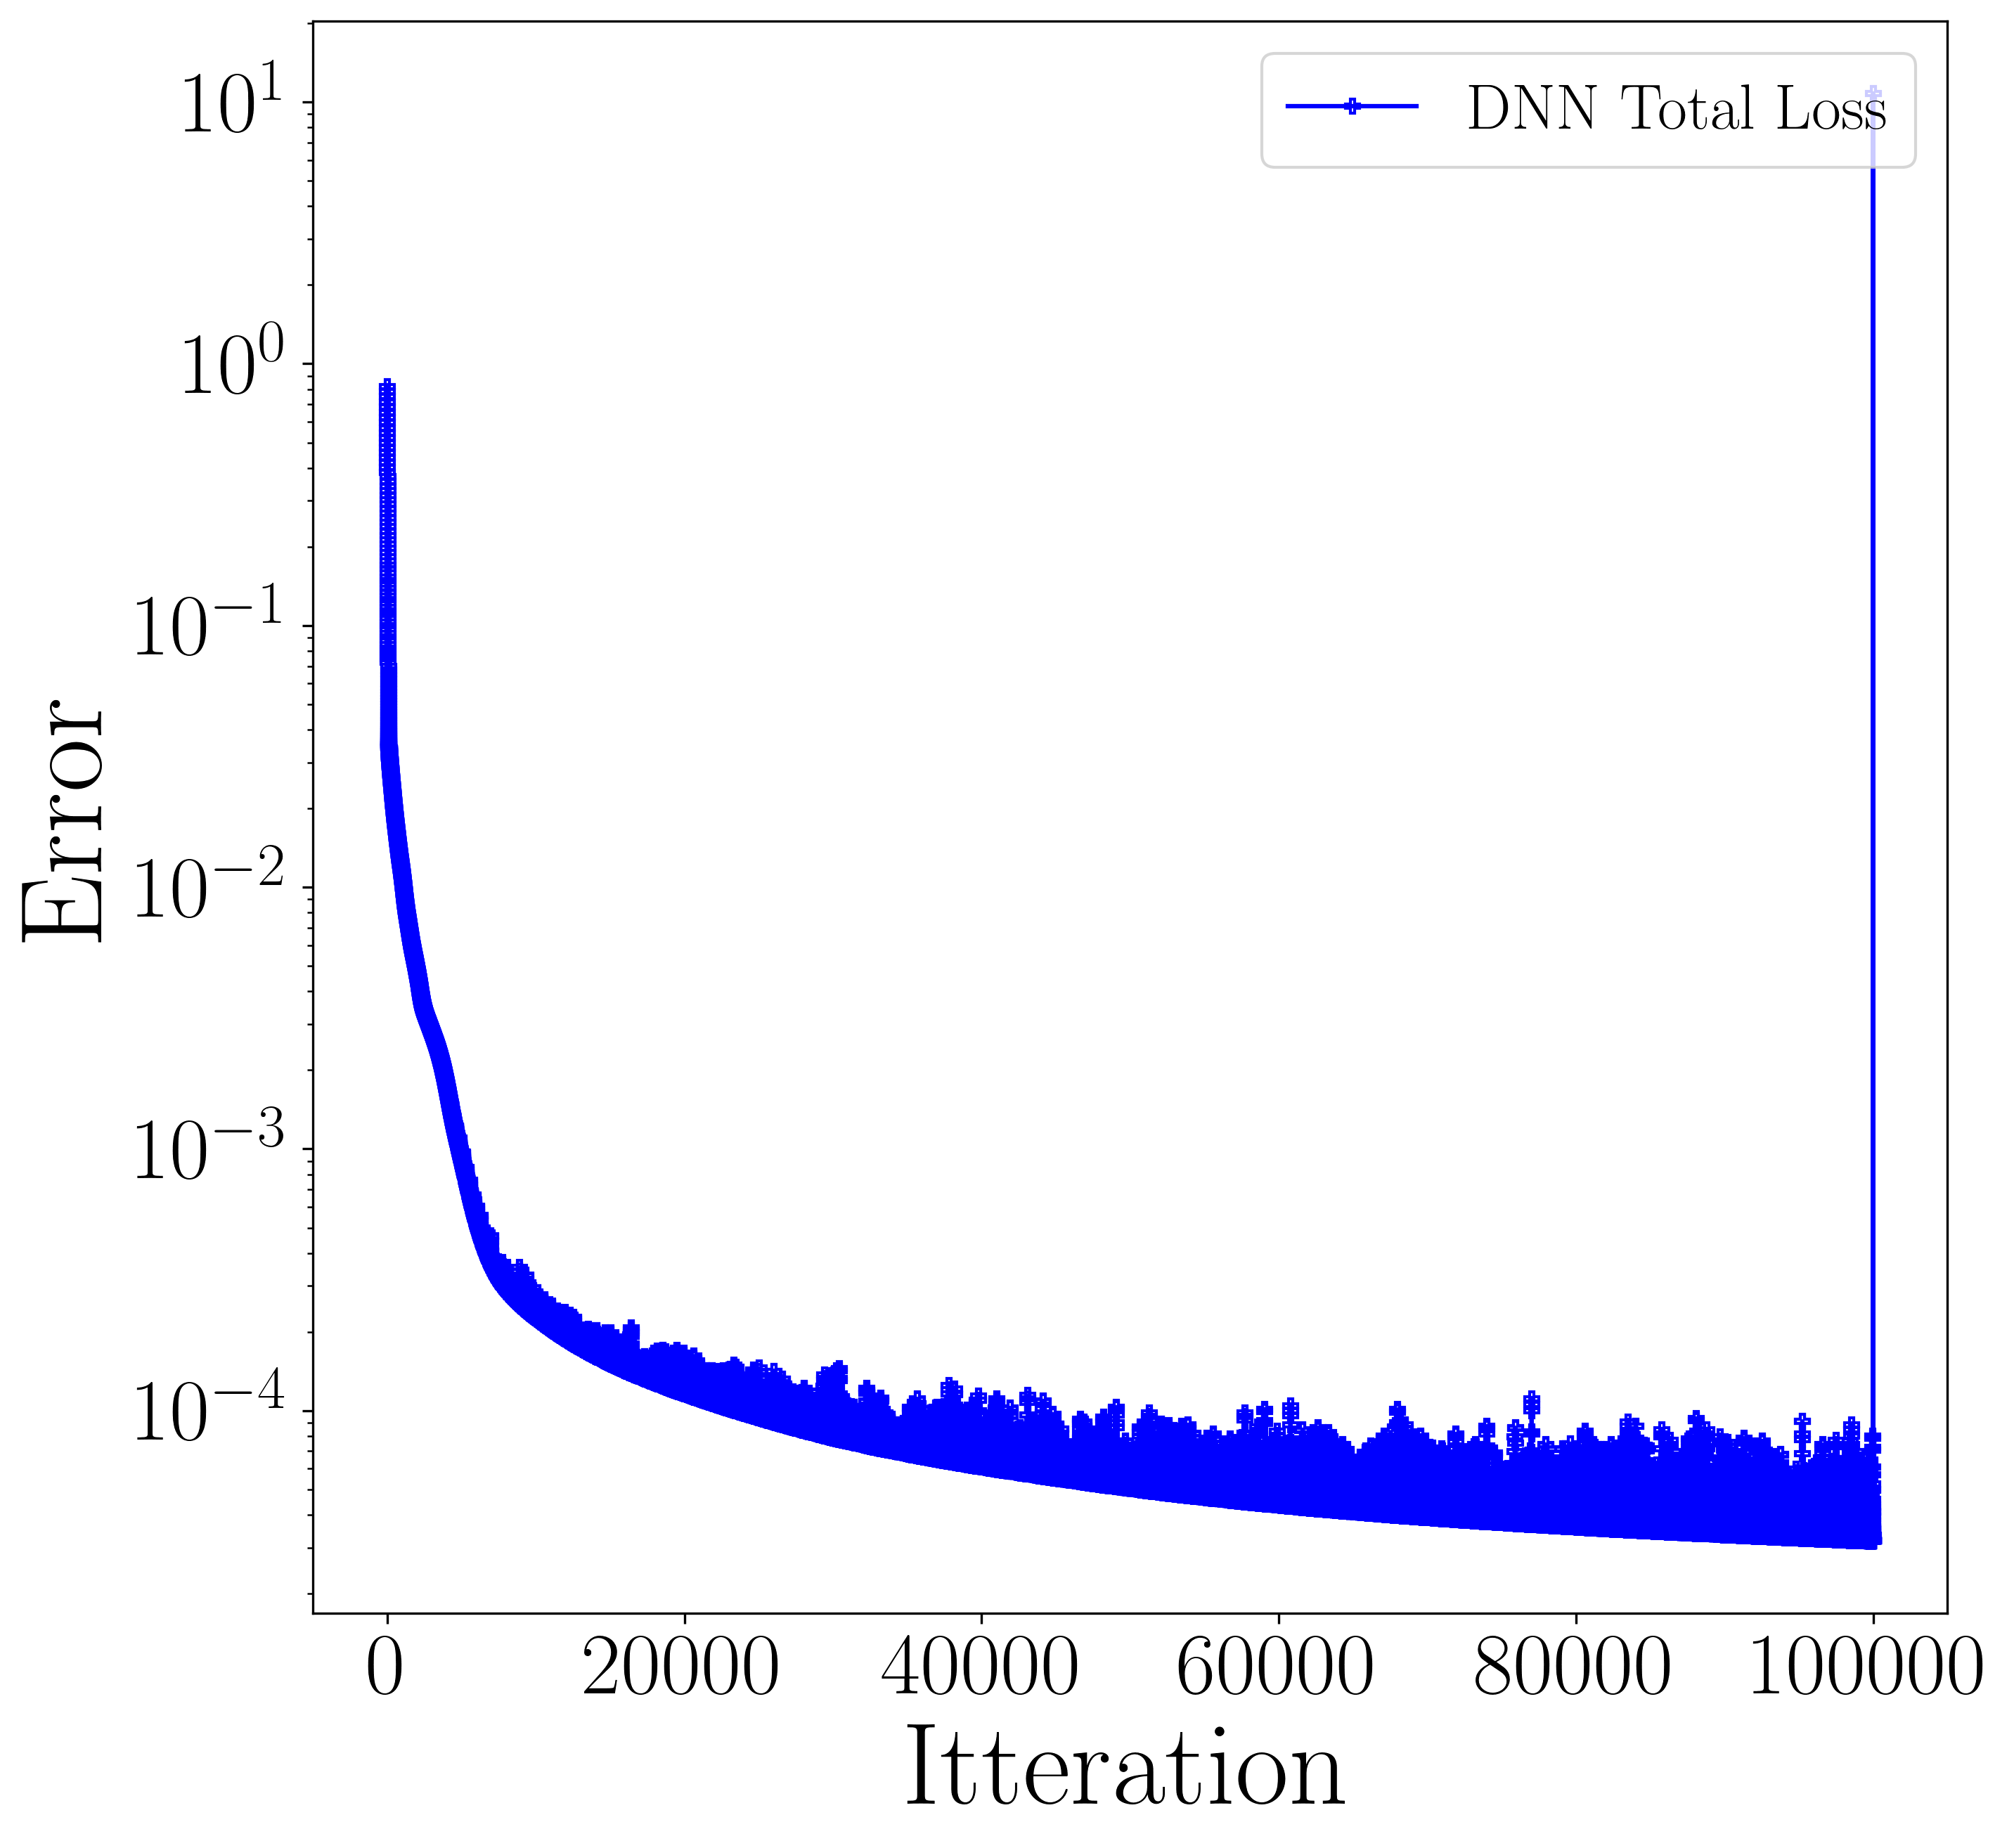

In [16]:
import matplotlib.font_manager
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

plt.figure(figsize=(10,10),dpi=300)

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=22)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(LOSS , 'bP-', markerfacecolor='none', linewidth=1.5, markersize = 5.0)

plt.xlabel('Itteration', fontname = 'Times New Roman', fontsize=40)
plt.ylabel('Error', fontname = 'Times New Roman', fontsize=40)
plt.legend(['DNN Total Loss','Loss of Low-Fidelity','Loss of High-Fidelity'],loc='upper right')
#plt.title('Actual and Predicted Flow Curve for a Random Batch')

plt.xticks(fontname = "Times New Roman", fontsize=30)
plt.yticks(fontname = "Times New Roman", fontsize=30)
#plt.ylim(0.6,13)
#plt.xscale("log")
plt.yscale("log")

#plt.savefig('Prediction_Batch09.png',bbox_inches = 'tight')

plt.show()

# Flow Curve

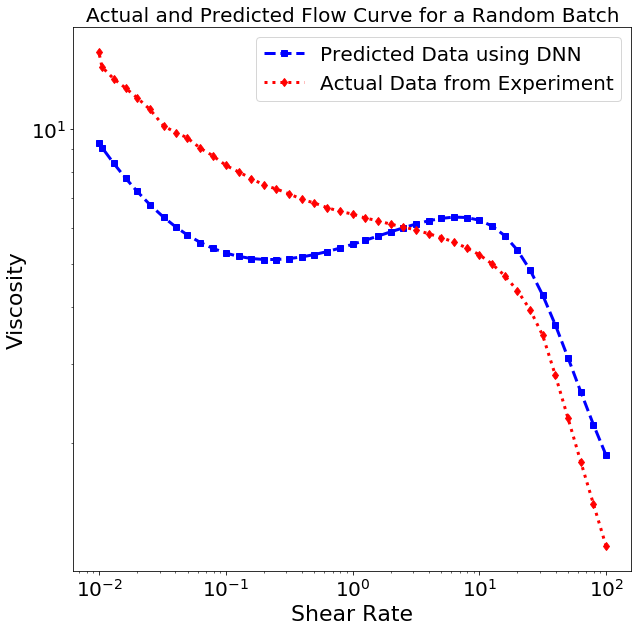

In [15]:
a=0*42
b=1*42

ShR = np.power(10,XH5_test[a:b])

plt.figure(figsize=(10,10))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(ShR,np.power(10,y_hf_test[a:b]), 'bs--', linewidth=3.0)
plt.plot(ShR,np.power(10,y_hf_ref[a:b]) , 'rd:', linewidth=3.0)

plt.xlabel('Shear Rate')
plt.ylabel('Viscosity')
plt.legend(['Predicted Data using DNN','Actual Data from Experiment'])
plt.title('Actual and Predicted Flow Curve for a Random Batch')

plt.xscale("log")
plt.yscale("log")

plt.show()

# Regression

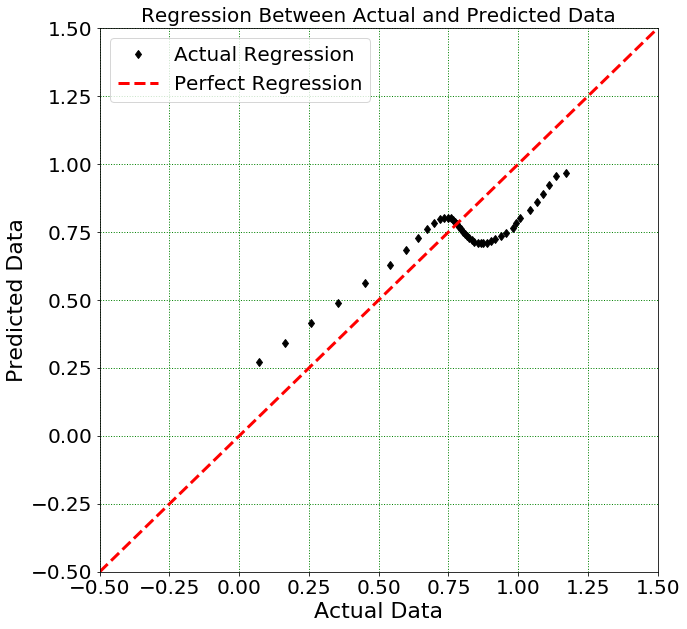

In [16]:
plt.figure(figsize=(10,10))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(y_hf_ref,y_hf_test, 'kd', linewidth=5.0)
plt.plot(np.linspace(-0.5, 1.5, 100),np.linspace(-0.5, 1.5, 100), 'r--', linewidth=3.0)
plt.xlabel('Actual Data')
plt.ylabel('Predicted Data')
plt.legend(['Actual Regression','Perfect Regression'])
plt.title('Regression Between Actual and Predicted Data')

plt.grid(color='g', linestyle=':', linewidth=1)

plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)

#plt.text(-4500, 11500, 'Pearson Regression Correlation is 0.94', style='italic',bbox={'facecolor': 'blue', 'alpha': 0.1, 'pad': 5})
#plt.savefig('00 Research Codes/02_Multi_Fidelity/With_Randy/FX1_linear_regression.png')

plt.show()

# Accuracy

In [17]:
Corr = np.corrcoef(list(y_hf_test.T),list(y_hf_ref.T))[0, 1]

Error = np.sqrt(np.square(y_hf_ref - y_hf_test))
Abs_mean_Error = sum(Error)/len(Error)

mError = 0
aError = 0
for i in range(0,len(y_hf_test)-1):
    a = y_hf_test[i] - y_hf_ref[i]
    b = a/(max(abs(y_hf_test[i]),abs(y_hf_ref[i])))
    c = b**2
    mError = mError + (c)
    aError = aError + abs(a)
mError = 100 * (mError**0.5) / len(y_hf_test)
aError = aError / len(y_hf_test)
print('Mean Absolute Error is :',aError,',And Mean Relative Error is :',mError, ',And Correlation is :',Corr)

#print(np.hstack((y_hf_ref,y_hf_test)))

Mean Absolute Error is : [0.12282148] ,And Mean Relative Error is : [3.26095119] ,And Correlation is : 0.9024122342821905
